In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/uas-statistika/Jan_2019_ontime.csv


In [17]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,classification_report,confusion_matrix
        
from sklearn.naive_bayes import BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from xgboost import XGBRFClassifier,XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.linear_model import SGDClassifier
from sklearn.multiclass import OneVsRestClassifier

from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import StandardScaler
sc=StandardScaler()

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [18]:
traindata0=pd.read_csv('/kaggle/input/uas-statistika/Jan_2019_ontime.csv')

In [19]:
traindata0.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_UNIQUE_CARRIER,OP_CARRIER_AIRLINE_ID,OP_CARRIER,TAIL_NUM,OP_CARRIER_FL_NUM,ORIGIN_AIRPORT_ID,ORIGIN,DEST_AIRPORT_ID,DEST,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_TIME,ARR_DEL15,CANCELLED,DIVERTED,DISTANCE
0,1,2,9E,20363,9E,N8688C,3280,11953,GNV,10397,ATL,601.0,0.0,0600-0659,722.0,0.0,0,0,300
1,1,2,9E,20363,9E,N348PQ,3281,13487,MSP,11193,CVG,1359.0,0.0,1400-1459,1633.0,0.0,0,0,596
2,1,2,9E,20363,9E,N8896A,3282,11433,DTW,11193,CVG,1215.0,0.0,1200-1259,1329.0,0.0,0,0,229
3,1,2,9E,20363,9E,N8886A,3283,15249,TLH,10397,ATL,1521.0,0.0,1500-1559,1625.0,0.0,0,0,223
4,1,2,9E,20363,9E,N8974C,3284,10397,ATL,11778,FSM,1847.0,0.0,1900-1959,1940.0,0.0,0,0,579


In [21]:
traindata0.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 19 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_UNIQUE_CARRIER      583985 non-null  object 
 3   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 4   OP_CARRIER             583985 non-null  object 
 5   TAIL_NUM               581442 non-null  object 
 6   OP_CARRIER_FL_NUM      583985 non-null  int64  
 7   ORIGIN_AIRPORT_ID      583985 non-null  int64  
 8   ORIGIN                 583985 non-null  object 
 9   DEST_AIRPORT_ID        583985 non-null  int64  
 10  DEST                   583985 non-null  object 
 11  DEP_TIME               567633 non-null  float64
 12  DEP_DEL15              567630 non-null  float64
 13  DEP_TIME_BLK           583985 non-null  object 
 14  ARR_TIME               566924 non-nu

In [22]:
#Mencari atribut yang berlebihan
traindata0.OP_UNIQUE_CARRIER.value_counts()

WN    111312
AA     77017
DL     73836
OO     64926
UA     46915
YX     25755
MQ     25699
B6     24443
OH     23169
AS     20744
9E     20198
YV     18346
NK     15222
EV     13195
F9      9647
HA      6798
G4      6763
Name: OP_UNIQUE_CARRIER, dtype: int64

In [23]:
traindata0.OP_CARRIER_AIRLINE_ID.value_counts()

19393    111312
19805     77017
19790     73836
20304     64926
19977     46915
20452     25755
20398     25699
20409     24443
20397     23169
19930     20744
20363     20198
20378     18346
20416     15222
20366     13195
20436      9647
19690      6798
20368      6763
Name: OP_CARRIER_AIRLINE_ID, dtype: int64

In [24]:
traindata0.OP_CARRIER.value_counts()

WN    111312
AA     77017
DL     73836
OO     64926
UA     46915
YX     25755
MQ     25699
B6     24443
OH     23169
AS     20744
9E     20198
YV     18346
NK     15222
EV     13195
F9      9647
HA      6798
G4      6763
Name: OP_CARRIER, dtype: int64

In [27]:
#Dari hasil di atas dapat disimpulkan bahwa OP_UNIQUE_CARRIER , OP_CARRIER_AIRLINE_ID, OP_CARRIER adalah fitur yang berlebihan.
# Oleh karena itu OP_UNIQUE_CARRIER dan OP_CARRIER dihapus, jadi hanya mempertahankan OP_CARRIER_AIRLINE_ID
#Selain itu ORIGIN_AIRPORT_ID dan ORIGIN adalah fitur yang berlebihan. jadi hanya mempertahankan ORIGIN_AIRPORT_ID
# demikian pula DEST_AIRPORT_ID dan DEST adalah fitur redundan sehingga hanya dapat mempertahankan DEST_AIRPORT_ID
# Tidak membutuhkan CANCELLED dan DIVERTED
#ARR_TIME dan ARR_DEL15 dapat dianggap sebagai variabel target, dapat menghilangkan ARR_TIME karena menganggap ARR_DEL15 sebagai target

traindata1=traindata0.drop(columns=['OP_UNIQUE_CARRIER','OP_CARRIER','ORIGIN_AIRPORT_ID',
                                    'ORIGIN','DEST_AIRPORT_ID','DEST',
                                   'CANCELLED','DIVERTED','ARR_TIME','TAIL_NUM'])

In [28]:
traindata1.head()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,DISTANCE
0,1,2,20363,3280,601.0,0.0,0600-0659,0.0,300
1,1,2,20363,3281,1359.0,0.0,1400-1459,0.0,596
2,1,2,20363,3282,1215.0,0.0,1200-1259,0.0,229
3,1,2,20363,3283,1521.0,0.0,1500-1559,0.0,223
4,1,2,20363,3284,1847.0,0.0,1900-1959,0.0,579


In [29]:
traindata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583985 entries, 0 to 583984
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           583985 non-null  int64  
 1   DAY_OF_WEEK            583985 non-null  int64  
 2   OP_CARRIER_AIRLINE_ID  583985 non-null  int64  
 3   OP_CARRIER_FL_NUM      583985 non-null  int64  
 4   DEP_TIME               567633 non-null  float64
 5   DEP_DEL15              567630 non-null  float64
 6   DEP_TIME_BLK           583985 non-null  object 
 7   ARR_DEL15              565963 non-null  float64
 8   DISTANCE               583985 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 40.1+ MB


In [30]:
# dapatkan persentase nilai nol di setiap atribut
traindata1.isnull().sum()/len(traindata1)*100  

DAY_OF_MONTH             0.000000
DAY_OF_WEEK              0.000000
OP_CARRIER_AIRLINE_ID    0.000000
OP_CARRIER_FL_NUM        0.000000
DEP_TIME                 2.800072
DEP_DEL15                2.800586
DEP_TIME_BLK             0.000000
ARR_DEL15                3.086038
DISTANCE                 0.000000
dtype: float64

In [31]:
#Karena persentase nilai nolnya sangat kecil, maka dapat menjatuhkan catatan nol alih-alih imputasi nilai NULL
traindata1.dropna(inplace=True)
traindata1.reset_index(drop=True,inplace=True)
traindata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565963 entries, 0 to 565962
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           565963 non-null  int64  
 1   DAY_OF_WEEK            565963 non-null  int64  
 2   OP_CARRIER_AIRLINE_ID  565963 non-null  int64  
 3   OP_CARRIER_FL_NUM      565963 non-null  int64  
 4   DEP_TIME               565963 non-null  float64
 5   DEP_DEL15              565963 non-null  float64
 6   DEP_TIME_BLK           565963 non-null  object 
 7   ARR_DEL15              565963 non-null  float64
 8   DISTANCE               565963 non-null  int64  
dtypes: float64(3), int64(5), object(1)
memory usage: 38.9+ MB


In [32]:
#Menganalisis variabel Kategorikal DEP_TIME_BLK
traindata1.DEP_TIME_BLK.value_counts()

0600-0659    40616
0800-0859    37868
0700-0759    37269
1700-1759    36098
1200-1259    35854
1100-1159    35771
1500-1559    34944
1400-1459    34786
1000-1059    34630
1600-1659    34255
0900-0959    33492
1800-1859    33376
1300-1359    32510
1900-1959    30761
2000-2059    25181
2100-2159    17133
0001-0559    15301
2200-2259    12596
2300-2359     3522
Name: DEP_TIME_BLK, dtype: int64

In [33]:
#Melakukan pemeriksaan jika kedua variabel kategori ini memiliki pengaruh terhadap variabel target.
#Ini dapat diuji menggunakan Chisquare Test of independence: H0: Tidak ada ketergantungan antara Fitur dan Target Ha: Ada ketergantungan
from scipy.stats import chi2_contingency
categorical_columns=['DEP_TIME_BLK']
chi2_check = []
for i in categorical_columns:
    ch2 , p_value , df, exp_freq=chi2_contingency(pd.crosstab(traindata1[i],traindata1['ARR_DEL15']))
    if p_value < 0.05:
        chi2_check.append('Reject Null Hypothesis: Retain the Feature:'+i)
    else:
        chi2_check.append('Fail to Reject Null Hypothesis: Drop the Feature:')
chi2_check

['Reject Null Hypothesis: Retain the Feature:DEP_TIME_BLK']

In [34]:
#Dari uji Chisquare perlu mempertahankan fitur kategorikal di atas
# DEP_TIME_BLK dapat diisi dengan nilai numerik
traindata1.DEP_TIME_BLK.replace(['0600-0659','0700-0759','0800-0859','1700-1759','1200-1259','1100-1159','1500-1559',
                                 '1000-1059','1400-1459','0900-0959','1600-1659','1800-1859','1300-1359','1900-1959',
                                 '2000-2059','2100-2159','0001-0559','2200-2259','2300-2359'],
                               [6,7,8,17,12,11,15,10,14,9,16,18,13,19,20,21,1,22,23],inplace=True)

In [35]:
traindata1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 565963 entries, 0 to 565962
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   DAY_OF_MONTH           565963 non-null  int64  
 1   DAY_OF_WEEK            565963 non-null  int64  
 2   OP_CARRIER_AIRLINE_ID  565963 non-null  int64  
 3   OP_CARRIER_FL_NUM      565963 non-null  int64  
 4   DEP_TIME               565963 non-null  float64
 5   DEP_DEL15              565963 non-null  float64
 6   DEP_TIME_BLK           565963 non-null  int64  
 7   ARR_DEL15              565963 non-null  float64
 8   DISTANCE               565963 non-null  int64  
dtypes: float64(3), int64(6)
memory usage: 38.9 MB


In [36]:
#Memeriksa korelasi antar variabel
traindata1.corr()

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_AIRLINE_ID,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,DEP_TIME_BLK,ARR_DEL15,DISTANCE
DAY_OF_MONTH,1.000000,-0.021999,-0.001235,-0.012975,-0.001515,0.027762,-0.005161,0.038639,-0.016014
DAY_OF_WEEK,-0.021999,1.000000,0.005142,0.059897,0.003763,-0.003089,0.006860,-0.000655,0.017024
OP_CARRIER_AIRLINE_ID,-0.001235,0.005142,1.000000,0.444965,0.005790,0.041485,0.001779,0.079238,-0.125062
OP_CARRIER_FL_NUM,-0.012975,0.059897,0.444965,1.000000,0.008770,0.026191,-0.000064,0.038640,-0.342549
DEP_TIME,-0.001515,0.003763,0.005790,0.008770,1.000000,0.190526,0.957224,0.143283,-0.026949
DEP_DEL15,0.027762,-0.003089,0.041485,0.026191,0.190526,1.000000,0.132346,0.719430,0.011393
DEP_TIME_BLK,-0.005161,0.006860,0.001779,-0.000064,0.957224,0.132346,1.000000,0.091318,-0.016101
ARR_DEL15,0.038639,-0.000655,0.079238,0.038640,0.143283,0.719430,0.091318,1.000000,0.003407
DISTANCE,-0.016014,0.017024,-0.125062,-0.342549,-0.026949,0.011393,-0.016101,0.003407,1.000000


In [37]:
#Dari matriks korelasi di atas terlihat bahwa terdapat beberapa variabel muticoliniarity
#Contoh:
#1. Terdapat korelasi yang sangat kuat antara DEP_TIME_BLK dan DEP_TIME (96%)
# 2. Ada juga korelasi yang mencolok antara OP_CARRIER_AIRLINE_ID dan OP_CARRIER_FL_NUM
# Oleh karena itu kita dapat mencoba melepaskan DEP_TIME_BLK dan OP_CARRIER_AIRLINE_ID

traindata2=traindata1.drop(columns=['DEP_TIME_BLK','OP_CARRIER_AIRLINE_ID'])

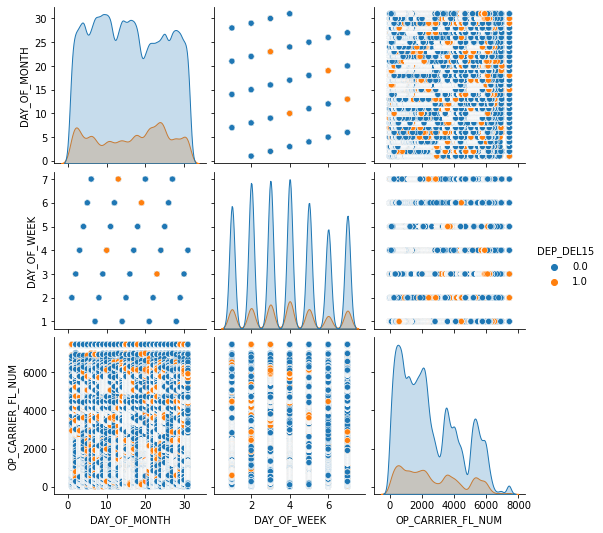

In [44]:
features=['DAY_OF_MONTH','DAY_OF_WEEK','OP_CARRIER_FL_NUM']

#memplot pasangan dan visualisasikan keterpisahan kelas


#plt.subplot(2,4,1)
sns.pairplot(traindata2,x_vars=features,y_vars=features,kind='scatter',hue='DEP_DEL15')
plt.show()

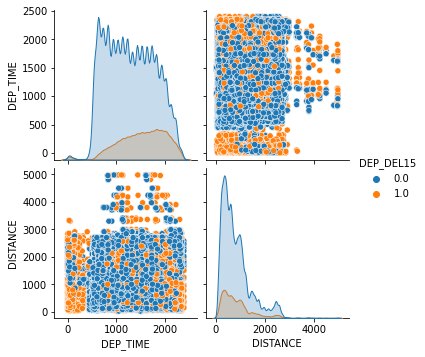

In [42]:
features=['DEP_TIME','DISTANCE']

#memplot pasangan dan visualisasikan keterpisahan kelas
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

#plt.subplot(2,4,1)
sns.pairplot(traindata2,x_vars=features,y_vars=features,kind='scatter',hue='DEP_DEL15')
plt.show()

In [45]:
# Dari plot pasangan di atas, variabel Target tidak dapat dipisahkan secara linear dengan sebagian besar fitur kecuali Dep_time
# Ekstrak fitur dan label
traindata2.head(1)

,DAY_OF_MONTH,DAY_OF_WEEK,OP_CARRIER_FL_NUM,DEP_TIME,DEP_DEL15,ARR_DEL15,DISTANCE
0,1,2,3280,601.0,0.0,0.0,300


In [46]:
features=traindata2.drop(columns=['ARR_DEL15']).values
label=traindata2['ARR_DEL15'].values

<AxesSubplot:ylabel='count'>

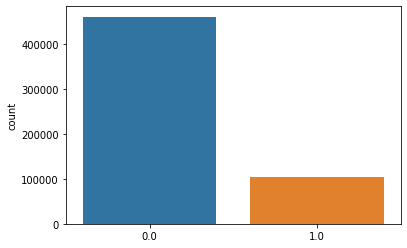

In [47]:
#Memeriksa keseimbangan data
sns.countplot(x=label)

In [48]:
#Split data menjadi Latih (Train) dan Uji (Test)
from sklearn.model_selection import train_test_split
X_train,X_test_final,y_train,y_test_final=train_test_split(features,label,test_size=0.2,random_state=12)
print('the shape of X_train and  y_train: ', X_train.shape, y_train.shape)
print('the shape of X_test and  y_test: ', X_test_final.shape,y_test_final.shape)


## Verifikasi kinerja berbagai model menggunakan Stratified-KFold Cross Validation

the shape of X_train and  y_train:  (452770, 6) (452770,)
the shape of X_test and  y_test:  (113193, 6) (113193,)


In [54]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import f1_score,classification_report,confusion_matrix
#from sklearn import metrics

def stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y):
    global df_model_selection
    
    skf = StratifiedKFold(n_splits, random_state=12,shuffle=True)
    
    weighted_f1_score = []
    #print(skf.split(X,y))
    for train_index, test_index in skf.split(X,y):
        X_train, X_test = X[train_index], X[test_index] 
        y_train, y_test = y[train_index], y[test_index]
        
        model_obj.fit(X_train, y_train)##### HERE ###
        test_ds_predicted = model_obj.predict( X_test ) ##### HERE ####   
        #print( metrics.classification_report( y_test, test_ds_predicted ) )    
        weighted_f1_score.append(round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2))
        
    sd_weighted_f1_score = np.std(weighted_f1_score, ddof=1)
    range_of_f1_scores = "{}-{}".format(min(weighted_f1_score),max(weighted_f1_score))    
    df_model_selection = pd.concat([df_model_selection,pd.DataFrame([[process,model_name,
                        sorted(weighted_f1_score),range_of_f1_scores,sd_weighted_f1_score]], columns =COLUMN_NAMES) ])

In [55]:
%%time

COLUMN_NAMES = ["Process","Model Name", "F1 Scores","Range of F1 Scores","Std Deviation of F1 Scores"]
df_model_selection = pd.DataFrame(columns=COLUMN_NAMES)

process='Stratified-KFold'
n_splits = 10
X=sc.fit_transform(X_train)
y=y_train

# Logistic Regression
model_LR=LogisticRegression()
model_obj=model_LR
model_name='Logistic Regression'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# Decesion Tree Classifier
model_DTC=DecisionTreeClassifier()
model_obj=model_DTC
model_name='Decesion Tree Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# Random Forest Classifier
model_RFC=RandomForestClassifier()
model_obj=model_RFC
model_name='Random Forest Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# XGBoost Classifier
model_XGBC=XGBClassifier()
model_obj=model_XGBC
model_name='XGBoost Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# Gradient Boosting Classifier
model_GBC=GradientBoostingClassifier()
model_obj=model_GBC
model_name='Gradient Boosting Classifier'
stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# XGBoost Random Forest Classifier
#model_XGBRFC=XGBRFClassifier()
#model_obj=model_XGBRFC
#model_name='XGBoost Random Forest Classifier'
#stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

# 8.Support Vector Machine Classifier
#model_SVC=SVC()
#model_obj=model_SVC
#model_name='Support Vector Machine Classifier'
#stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)


# 9.SGD Classifier
#model_sgd = OneVsRestClassifier(SGDClassifier())
#model_obj=model_sgd
#model_name='Stochastic Gradient Descent Classifier'
#stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)


#11.KNeighborsClassifier
#model_KNNC=KNeighborsClassifier()
#model_obj=model_KNNC
#model_name='K Nearst Neighbour Classifier'
#stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#12 Linear Discriminant Analysis
#model_LDA=LinearDiscriminantAnalysis()
#model_obj=model_LDA
#model_name='Linear Discriminant Analysis'
#stratified_K_fold_validation(model_obj, model_name, process, n_splits, X, y)

#Exporting the results to csv
#df_model_selection.to_csv("Model_statistics.csv",index = False)
df_model_selection

CPU times: user 41min 30s, sys: 14.1 s, total: 41min 44s
Wall time: 33min 1s


,Process,Model Name,F1 Scores,Range of F1 Scores,Std Deviation of F1 Scores
0,Stratified-KFold,Logistic Regression,"[0.91, 0.91, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9...",0.91-0.92,0.004216
0,Stratified-KFold,Decesion Tree Classifier,"[0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.86, 0.8...",0.86-0.86,0.000000
0,Stratified-KFold,Random Forest Classifier,"[0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.91, 0.9...",0.91-0.92,0.003162
0,Stratified-KFold,XGBoost Classifier,"[0.91, 0.91, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9...",0.91-0.92,0.004216
0,Stratified-KFold,Gradient Boosting Classifier,"[0.91, 0.91, 0.92, 0.92, 0.92, 0.92, 0.92, 0.9...",0.91-0.92,0.004216


In [59]:
#Mencari sampel terbaik dari 10 pembagian
#Mencari Skor menggunakan StratifiedKFold Cross Validation
#Inisialisasi algo
model=LogisticRegression()

#Menginisialisasi Metode StratifiedKFold
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, 
              random_state=1,
              shuffle=True)

#Menginisialisasi Untuk Loop
i=0
for train,test in kfold.split(X,y):
    i = i+1
    X_train,X_test = X[train],X[test]
    y_train,y_test = y[train],y[test]
    
    model.fit(X_train,y_train)
    test_ds_predicted=model.predict(X_test)
    train_ds_predicted=model.predict(X_train)
    
    test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
    train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
    
    #print("Train Score: {}, Test score: {}, for Sample Split: {}".format(model.score(X_train,y_train),model.score(X_test,y_test),i))
    print("Train f1-Score: {}, Test f1-score: {}, for Sample Split: {}".format(train_f1_score,test_f1_score,i))

Train f1-Score: 0.92, Test f1-score: 0.91, for Sample Split: 1
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 2
Train f1-Score: 0.92, Test f1-score: 0.91, for Sample Split: 3
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 4
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 5
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 6
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 7
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 8
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 9
Train f1-Score: 0.92, Test f1-score: 0.92, for Sample Split: 10


In [60]:
#Mengekstrak sampel Latih dan Uji untuk split 9
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, #n_splits should be equal to no of cv value in cross_val_score
              random_state=1,
              shuffle=True)
i=0
for train,test in kfold.split(X,y):
    i = i+1
    if i == 9:
        X_train,X_test,y_train,y_test = X[train],X[test],y[train],y[test]

#Final Model
finalModel=LogisticRegression()
finalModel.fit(X_train,y_train)

test_ds_predicted=model.predict(X_test)
train_ds_predicted=model.predict(X_train)

test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
print("Train f1-Score: {}, Test f1-score: {}".format(train_f1_score,test_f1_score))


train_score=np.round(finalModel.score(X_train,y_train),2)
test_score=np.round(finalModel.score(X_test,y_test),2)
print('Train Accuracy Score is:{} and  Test Accuracy Score:{}'.format(train_score,test_score))

#Classification Report
cr=classification_report(y_true=y_test,y_pred=finalModel.predict(X_test))
print(cr)

Train f1-Score: 0.92, Test f1-score: 0.92
Train Accuracy Score is:0.92 and  Test Accuracy Score:0.92
              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     36861
         1.0       0.80      0.75      0.77      8416

    accuracy                           0.92     45277
   macro avg       0.87      0.85      0.86     45277
weighted avg       0.92      0.92      0.92     45277



In [61]:
#Menguji model dalam kumpulan data yang tidak diketahui: X_test_final dan y_test_final
X_test_final=sc.fit_transform(X_test_final)
cr=classification_report(y_true=y_test_final,y_pred=finalModel.predict(X_test_final))
print(cr)

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     92125
         1.0       0.80      0.74      0.77     21068

    accuracy                           0.92    113193
   macro avg       0.87      0.85      0.86    113193
weighted avg       0.92      0.92      0.92    113193



In [66]:
## Mencoba Neural Network
import tensorflow as tf
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dropout, Dense

print('the shape of X_train and  y_train: ', X_train.shape, y_train.shape)
print('the shape of X_test and  y_test: ', X_test_final.shape,y_test_final.shape)

the shape of X_train and  y_train:  (407493, 6) (407493,)
the shape of X_test and  y_test:  (113193, 6) (113193,)


In [69]:
%%time
#Membangun model berurutan
tf.keras.backend.clear_session()

#Inisialisasi model Berurutan
model_NN = tf.keras.models.Sequential()
#Menginput Layer
model_NN.add(tf.keras.layers.Reshape((8,),input_shape=(8,)))
#Menormalkan data
model_NN.add(tf.keras.layers.BatchNormalization())

#Menambahkan Layer tersembunyi pertama
model_NN.add(tf.keras.layers.Dense(100, activation='relu'))
#Dropout layer
#model_NN.add(tf.keras.layers.Dropout(0.5))
#Menormalkan data
model_NN.add(tf.keras.layers.BatchNormalization())

#Menambahkan layer tersembunyi kedua
model_NN.add(tf.keras.layers.Dense(50, activation='relu'))
#Dropout layer
#model_NN.add(tf.keras.layers.Dropout(0.3))
#Normalize the data
model_NN.add(tf.keras.layers.BatchNormalization())

#Menambhakan OUTPUT layer
model_NN.add(tf.keras.layers.Dense(1, activation='sigmoid'))

#Buat pengoptimal dengan tingkat pembelajaran non-default
#sgd_optimizer = tf.keras.optimizers.SGD(lr=1.0)
#model_NN.compile(optimizer=sgd_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

#Mengkompilasi model
model_NN.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])
#model_NN.compile(optimizer='rmsprop',loss='binary_crossentropy',metrics=['accuracy'])

CPU times: user 87.7 ms, sys: 2.01 ms, total: 89.7 ms
Wall time: 88.9 ms


the shape of X_train and  y_train:  (452770, 6) (452770,)
the shape of X_test and  y_test:  (113193, 6) (113193,)
length of X_train and y_train before Oversampling 452770 452770
length of X_train and y_train after Oversampling 737232 737232


<AxesSubplot:ylabel='count'>

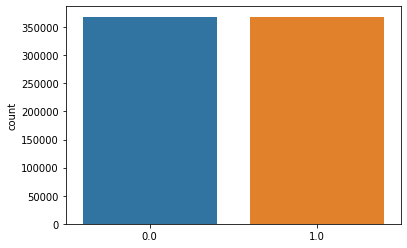

In [71]:
# Karena Data tidak seimbang, kita dapat mencoba menggunakan teknik Oversampling() dan melihat apakah kita dapat meningkatkan kinerja model
# Teknik penyeimbangan data dapat diterapkan onöy pada set data Latih

#Split data menjadi Train, Validation dan Test Set
from sklearn.model_selection import train_test_split
X_train,X_test_final,y_train,y_test_final=train_test_split(features,label,test_size=0.2,random_state=12)
print('the shape of X_train and  y_train: ', X_train.shape, y_train.shape)
print('the shape of X_test and  y_test: ', X_test_final.shape,y_test_final.shape)


from imblearn.over_sampling import SMOTE
print('length of X_train and y_train before Oversampling',len(X_train),len(y_train))

OS=SMOTE(random_state=42)
X_train_OS,y_train_OS=OS.fit_resample(X_train,y_train)

print('length of X_train and y_train after Oversampling',len(X_train_OS),len(y_train_OS))

#Check for data balance
sns.countplot(x=y_train_OS)

In [72]:
%%time
# Menerapkan validasi silang
#Inisialisasi algo
model=LogisticRegression()

X_train_OS=sc.fit_transform(X_train_OS) # scale the data

#Menginisialisasi Metode StratifiedKFold
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, 
              random_state=1,
              shuffle=True)

#Menginisialisasi Untuk Loop
i=0
for train,test in kfold.split(X_train_OS,y_train_OS):
    i = i+1
    X_train,X_test = X_train_OS[train],X_train_OS[test]
    y_train,y_test = y_train_OS[train],y_train_OS[test]
    
    model.fit(X_train,y_train)
    test_ds_predicted=model.predict(X_test)
    train_ds_predicted=model.predict(X_train)
    
    test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
    train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
    
    #print("Train Score: {}, Test score: {}, for Sample Split: {}".format(model.score(X_train,y_train),model.score(X_test,y_test),i))
    print("Train f1-Score: {}, Test f1-score: {}, for Sample Split: {}".format(train_f1_score,test_f1_score,i))

Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 1
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 2
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 3
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 4
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 5
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 6
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 7
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 8
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 9
Train f1-Score: 0.87, Test f1-score: 0.87, for Sample Split: 10
CPU times: user 28.9 s, sys: 16.5 s, total: 45.5 s
Wall time: 15.8 s


In [73]:
#Mengekstrak sampel Latih dan Uji untuk split 2
from sklearn.model_selection import StratifiedKFold
kfold = StratifiedKFold(n_splits=10, #n_splits should be equal to no of cv value in cross_val_score
              random_state=1,
              shuffle=True)
i=0
for train,test in kfold.split(X_train_OS,y_train_OS):
    i = i+1
    if i == 2:
        X_train,X_test,y_train,y_test = X_train_OS[train],X_train_OS[test],y_train_OS[train],y_train_OS[test]

#Final Model
finalModel=LogisticRegression()
finalModel.fit(X_train,y_train)

test_ds_predicted=model.predict(X_test)
train_ds_predicted=model.predict(X_train)

test_f1_score=round(f1_score(y_true=y_test, y_pred=test_ds_predicted , average='weighted'),2)
train_f1_score=round(f1_score(y_true=y_train, y_pred=train_ds_predicted , average='weighted'),2)
print("Train f1-Score: {}, Test f1-score: {}".format(train_f1_score,test_f1_score))


train_score=np.round(finalModel.score(X_train,y_train),2)
test_score=np.round(finalModel.score(X_test,y_test),2)
print('Train Accuracy Score is:{} and  Test Accuracy Score:{}'.format(train_score,test_score))

#Classification Report
cr=classification_report(y_true=y_test,y_pred=finalModel.predict(X_test))
print(cr)

Train f1-Score: 0.87, Test f1-score: 0.87
Train Accuracy Score is:0.87 and  Test Accuracy Score:0.87
              precision    recall  f1-score   support

         0.0       0.81      0.96      0.88     36862
         1.0       0.95      0.78      0.86     36862

    accuracy                           0.87     73724
   macro avg       0.88      0.87      0.87     73724
weighted avg       0.88      0.87      0.87     73724



In [74]:
#Menguji model dalam kumpulan data yang tidak diketahui: X_test_final and y_test_final
X_test_final=sc.fit_transform(X_test_final)
cr=classification_report(y_true=y_test_final,y_pred=finalModel.predict(X_test_final))
print(cr)

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95     92125
         1.0       0.80      0.74      0.77     21068

    accuracy                           0.92    113193
   macro avg       0.87      0.85      0.86    113193
weighted avg       0.92      0.92      0.92    113193

